In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

In [190]:
def summary(dtf):
    sumary=pd.concat([dtf.isna().sum(),((dtf == 0).sum())/dtf.shape[0],dtf.dtypes], axis=1)
    sumary=sumary.rename(columns={sumary.columns[0]: 'NaN'})
    sumary=sumary.rename(columns={sumary.columns[1]: 'Zeros'})
    sumary=sumary.rename(columns={sumary.columns[2]: 'Type'})
    sumary['NaN']=sumary['NaN'].astype(str)+' ('+((sumary['NaN']*100/dtf.shape[0]).astype(int)).astype(str)+'%)'
    sumary['Zeros']=(sumary['Zeros']*100).astype(int)
    sumary['Zeros']=(dtf == 0).sum().astype(str)+' ('+sumary['Zeros'].astype(str)+'%)'
    sumary=sumary[['Type','NaN','Zeros']]
    return print(sumary)

In [191]:
df=pd.read_csv("resraurantDelivery - Data.csv")

In [192]:
df.columns

Index(['Created Date', 'Country', 'City', 'Restaurant ID', 'Restaurant Name',
       'Order State', 'Cancel Reason', 'Cuisine', 'Platform', 'Payment Method',
       'Card Issuer', 'Products in Order', 'Order Value € (Gross)',
       'Delivery Fee', 'Delivery Time'],
      dtype='object')

# Cleaning

In [183]:
# Renaming columns for better usability

df.rename(columns={'Created Date':'date', 'Country':'country', 'City':'city', 'Restaurant ID':'restaurant_id',
        'Restaurant Name':'name','Order State':'order_state', 'Cancel Reason':'cancel_reason', 
                   'Cuisine':'cuisine', 'Platform':'platform', 'Payment Method':'pay_method',
       'Card Issuer':'card_issuer', 'Products in Order':'product_order_count', 'Order Value € (Gross)':'cost',
       'Delivery Fee':'delivery_fee', 'Delivery Time':'delivery_time'}, inplace=True
         )

In [184]:
df=df[['date', 'country', 'city', 'restaurant_id', 'name', 'order_state',
       'cancel_reason', 'cuisine',
       #'platform', 'pay_method', 'card_issuer',
       'product_order_count', 'cost', 'delivery_fee', 'delivery_time']].copy()

In [187]:
df.shape

(99618, 12)

In [185]:
summary(df)
df.head()

                        Type          NaN        Zeros
date                  object       0 (0%)       0 (0%)
country               object       0 (0%)       0 (0%)
city                  object       0 (0%)       0 (0%)
restaurant_id          int64       0 (0%)       0 (0%)
name                  object       0 (0%)       0 (0%)
order_state           object       0 (0%)       0 (0%)
cancel_reason         object  97936 (98%)       0 (0%)
cuisine               object     327 (0%)       0 (0%)
product_order_count    int64       0 (0%)       0 (0%)
cost                  object    1682 (1%)       0 (0%)
delivery_fee         float64    1682 (1%)  83652 (83%)
delivery_time        float64    1682 (1%)      10 (0%)


,date,country,city,restaurant_id,name,order_state,cancel_reason,cuisine,product_order_count,cost,delivery_fee,delivery_time
0,28.02.2020,Portugal,Lisbon,7238,Chirashi - Alvalade,delivered,NaN,Sushi,13,€89.30,0.0,17.7
1,28.02.2020,Portugal,Lisbon,12758,Istanbul Kebab Pizza - Alameda,delivered,NaN,Pizza,1,€10.00,0.0,16.3
2,28.02.2020,Portugal,Lisbon,6631,A-100 - Lisboa,delivered,NaN,Burgers,2,€16.96,0.0,13.6
3,28.02.2020,Portugal,Lisbon,10535,La Paparrucha - Parrilla Argentina,delivered,NaN,South American,3,€25.15,4.2,26.1
4,28.02.2020,Portugal,Lisbon,9695,Choupana Caffe,delivered,NaN,Brunch,3,€16.00,0.0,11.6


In [115]:
df['cost']=df['cost'].str.replace('€','').astype(float)

In [116]:
df['date']=pd.to_datetime(df['date'],infer_datetime_format=True)

In [117]:
# Generate AVG delivery time for a given restaurant
def mean_delivery_time_restaurant(restaurant_id):
   return df[df['restaurant_id']==restaurant_id]['delivery_time'].mean()

In [118]:
df['delivery_time'] = pd.to_numeric(df['delivery_time'], errors='coerce')

# Function to fill zero delivery times with the average for the respective restaurant
def fill_zero_delivery_time(row):
    if row['delivery_time'] == 0:
        return mean_delivery_time_restaurant(row['restaurant_id'])
    else:
        return row['delivery_time']

# Apply the function to fill zero values
df['delivery_time'] = df.apply(fill_zero_delivery_time, axis=1)

In [119]:
df[df['delivery_time']==0]

,date,country,city,restaurant_id,name,order_state,cancel_reason,cuisine,product_order_count,cost,delivery_fee,delivery_time


The missing values in the 'Delivery Time' column have been filled with the mean delivery time for the respective restaurant.
Also for this data, we cannot check for duplicates as there can be repeat orders throughtout a day even from same restaurant


# Seasonality Analysis

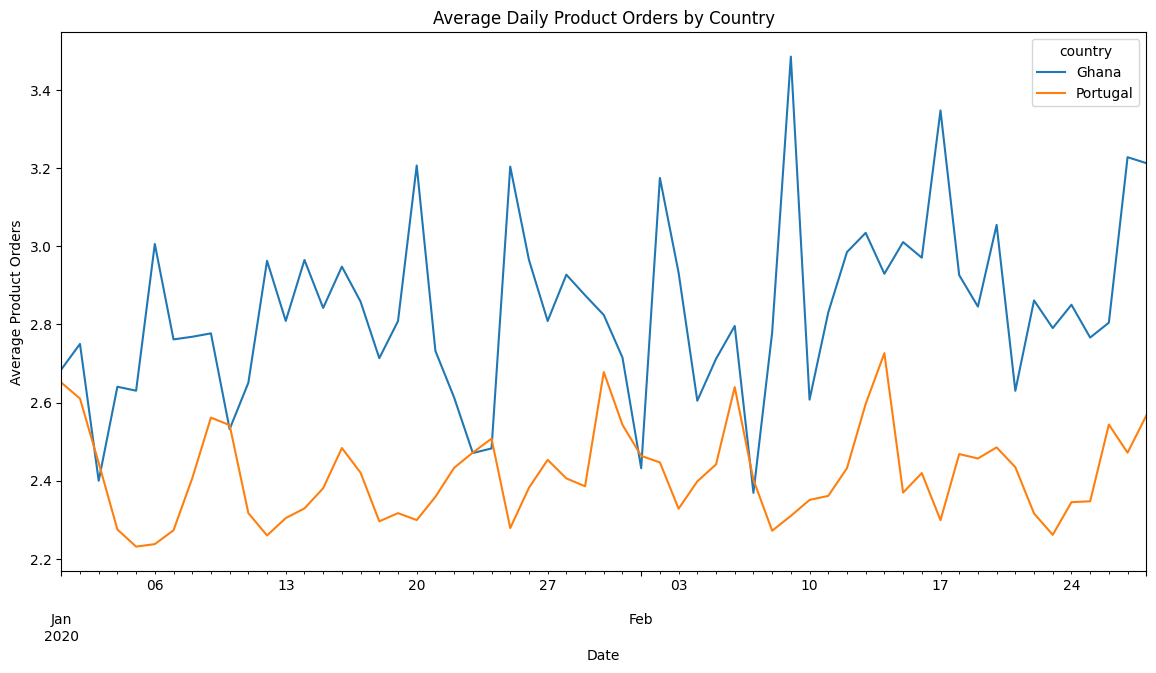

In [120]:
# Calculate the mean product orders for each country on a daily basis
mean_daily_orders_by_country = df.groupby(['date', 'country'])['product_order_count'].mean().unstack()

# Plot the seasonality of product orders for each country
mean_daily_orders_by_country.plot(figsize=(14, 7), title='Average Daily Product Orders by Country')
plt.ylabel('Average Product Orders')
plt.xlabel('Date')
plt.show()

Based on the plot showing the mean daily product orders by country, it appears that there is some level of seasonality in the orders across different countries which can be npticed by recurring cylindrical patterns. However, to confirm the presence and extent of seasonality between the countries' orders, further statistical analysis and modeling is necessary. This could involve time series analysis, seasonal decomposition, or more advanced modeling techniques few of which I have tried below

In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare the data for time series analysis

min_date = df['date'].min()
max_date = df['date'].max()
date_range = pd.date_range(start=min_date, end=max_date)
preds=pd.DataFrame()

# Initialize a DataFrame to hold the complete time series data
ts_df = pd.DataFrame(date_range, columns=['date'])

# Merge with the original data to fill in missing dates with 0 order count
for country in df['country'].unique():
    country_orders = df[df['country'] == country].groupby('date')['product_order_count'].sum().reset_index()
    ts_df = ts_df.merge(country_orders, on='date', how='left')
    ts_df = ts_df.rename(columns={'product_order_count': country})
    ts_df[country] = ts_df[country].fillna(0)

# Apply a linear regression model to predict the future orders
predictions = {}

for country in df['country'].unique():
    X = np.arange(len(ts_df)).reshape(-1, 1) 
    y = ts_df[country].values 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict the orders for March 2020
    march_dates = pd.date_range(start='2020-03-01', end='2020-03-31')
    march_day_index = np.arange(len(ts_df), len(ts_df) + len(march_dates)).reshape(-1, 1)
    march_predictions = model.predict(march_day_index)
    preds[country]=march_predictions
    predictions[country] = np.sum(march_predictions)

print("Linear Regression forecasts for predicted order numbers:")
for country, total_orders in predictions.items():
    print(f'{country}: {total_orders:.0f} orders predicted for March 2020')

Linear Regression forecasts for predicted order numbers:
Portugal: 161613 orders predicted for March 2020
Ghana: 35017 orders predicted for March 2020


On an obvious note , above figures are not too close or too correct but just an approximate linear forecast. Have tried
seasonal decomposing to produce seasonality plots which gives more clarity that there is a seasonality within
the orders in the countries. Have also implemented the SARIMAX model to make a more accurate prediction for March

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/stat

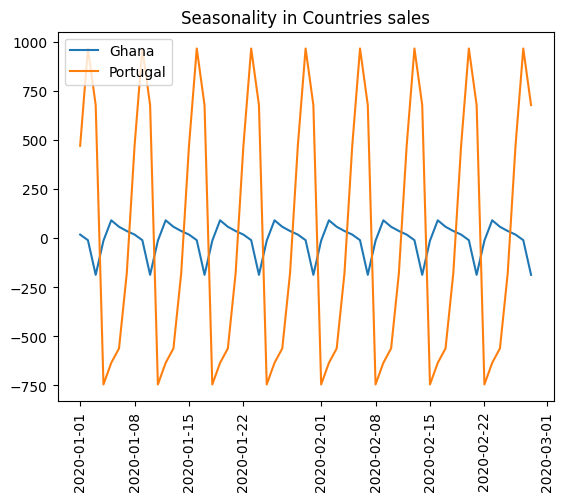

In [154]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the data
file_path = 'task2.csv'
df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')


daily_order_count_by_country = df.groupby(['country', df.index]).agg({'product_order_count': 'sum'}).reset_index()


predictions_by_country = {}

# Loop through each country and make predictions for March
for country in daily_order_count_by_country['country'].unique():
    # Filter the data for the current country
    country_data = daily_order_count_by_country[daily_order_count_by_country['country'] == country]
    country_data.set_index('date', inplace=True)
    country_data = country_data.asfreq('D').fillna(0) 


    # Decompose the time series to observe its components
    result = seasonal_decompose(country_data['product_order_count'], model='additive')
    plt.plot(result.seasonal,label='%s'%country)
    plt.legend(loc="upper left")
    plt.xticks(rotation=90)
    plt.title('Seasonality in Countries sales')

    # For simplicity, I have used a basic configuration
    model = SARIMAX(country_data['product_order_count'], order=(1, 1, 2), seasonal_order=(1, 1, 2, 12))
    model_fit = model.fit(disp=False)

    # Make predictions for the next month (March)
    predictions = model_fit.get_forecast(steps=31)
    predicted_mean = predictions.predicted_mean
    predictions_by_country[country] = predicted_mean

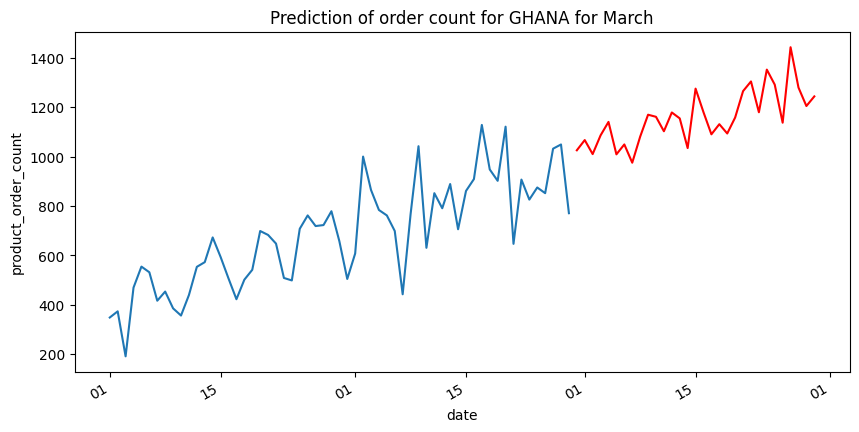

In [155]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=daily_order_count_by_country[daily_order_count_by_country['country']=='Ghana']
             ,x='date',y='product_order_count')
date_form = DateFormatter("%d")
ax.xaxis.set_major_formatter(date_form)
predictions_by_country['Ghana'].plot(color='r')
plt.title('Prediction of order count for GHANA for March')
plt.show()

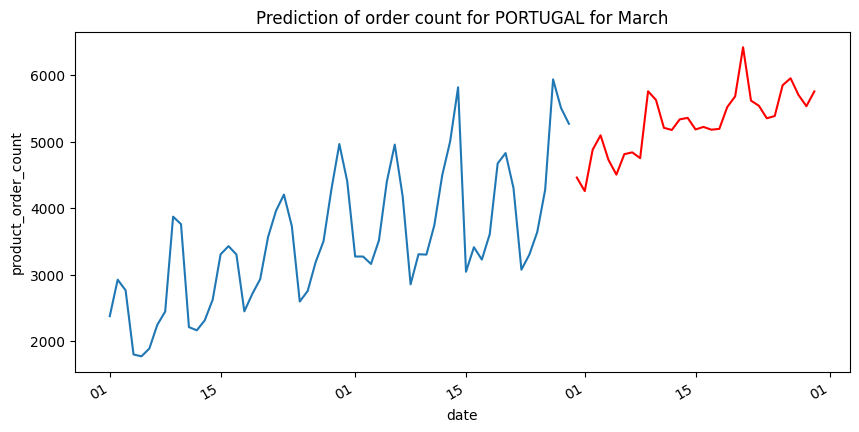

In [156]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=daily_order_count_by_country[daily_order_count_by_country['country']=='Portugal']
             ,x='date',y='product_order_count')
date_form = DateFormatter("%d")
ax.xaxis.set_major_formatter(date_form)
predictions_by_country['Portugal'].plot(color='r')
plt.title('Prediction of order count for PORTUGAL for March')
plt.show()

In [162]:
print("SARIMAX forecasts for predicted order numbers in March:")
print("Ghana :"+str(round(predictions_by_country['Ghana'].sum())))
print("Portugal :"+str(round(predictions_by_country['Portugal'].sum())))

SARIMAX forecasts for predicted order numbers in March:
Ghana :35868
Portugal :163878


# Insights

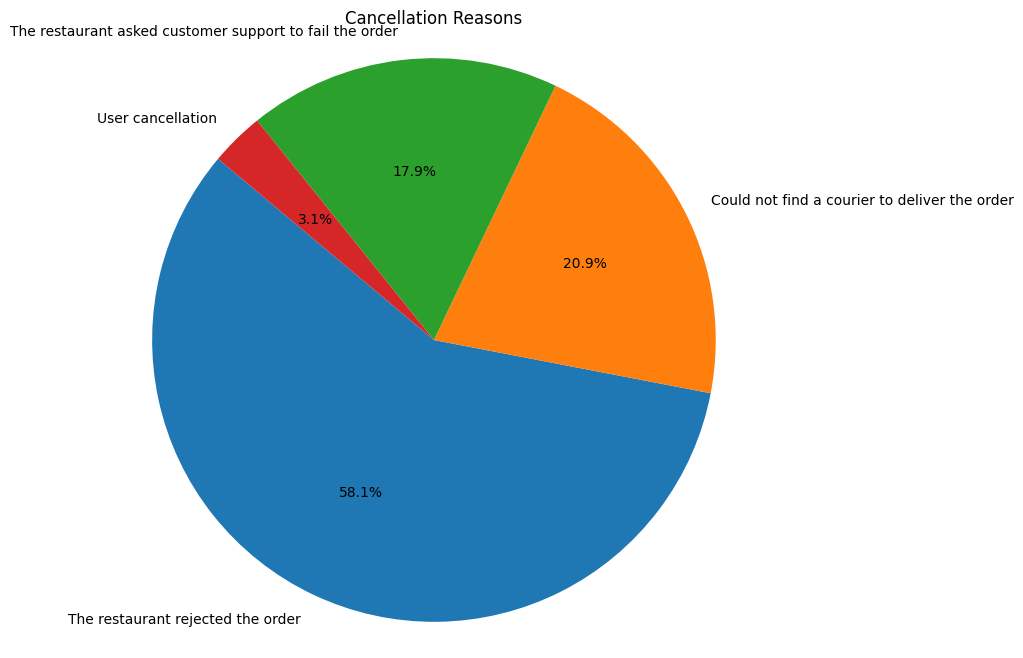

In [125]:
# Cancellations by restaurant analysis
plt.figure(figsize=(8, 8))
labels = df['cancel_reason'].value_counts().index
sizes = df['cancel_reason'].value_counts().values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Cancellation Reasons')
plt.show()

Above plot depicts that 58% of the rejected orders are actually rejected by restaurants and actually is not a 
concern regarding driver . Another minor 20% is due to inability to locate drivers which could be improved at 
operations level.


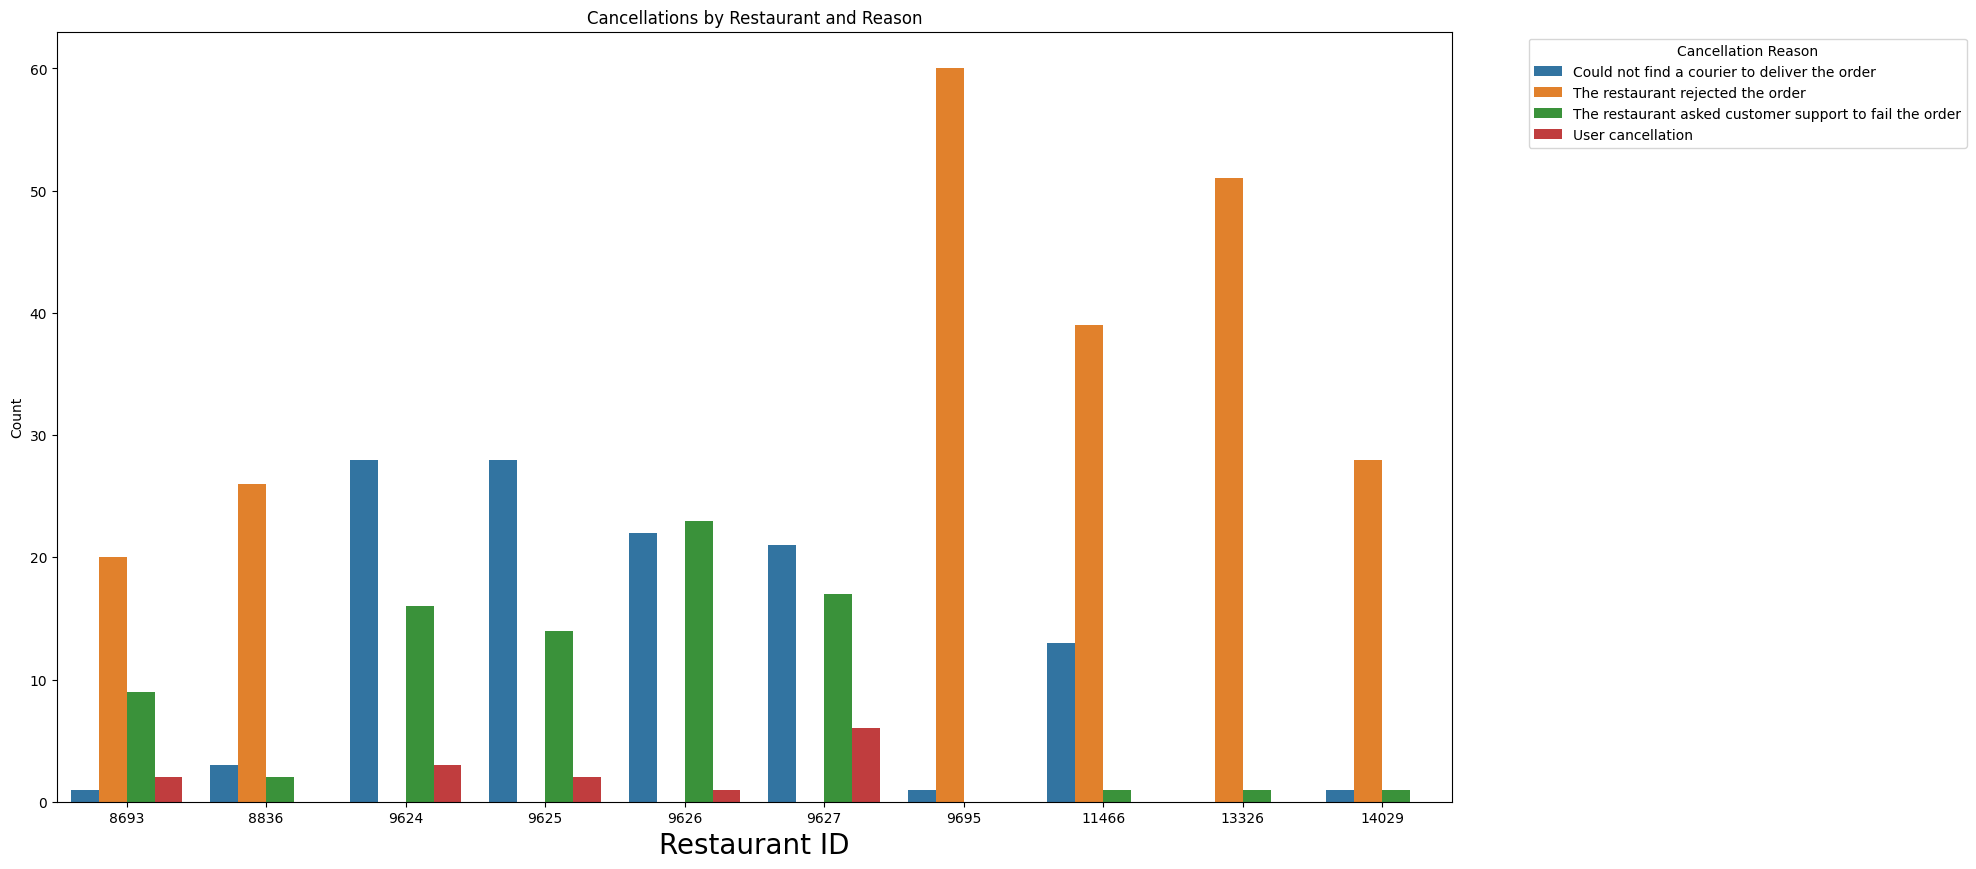

In [126]:
restaurant_cancellation_count = df[df['cancel_reason'].notnull()].groupby('restaurant_id')['cancel_reason'].count()

# Visualization of restaurants with the most cancellations and their reasons
top_restaurants = restaurant_cancellation_count.nlargest(10)
restaurant_cancellation_reasons = df[df['restaurant_id'].isin(top_restaurants.index)][['restaurant_id', 'cancel_reason']]

# Countplot of cancellations by restaurant and their reasons
plt.figure(figsize=(18, 10))
sns.countplot(data=restaurant_cancellation_reasons, x='restaurant_id', hue='cancel_reason')
plt.title('Cancellations by Restaurant and Reason')
plt.xlabel('Restaurant ID',fontsize=20)
plt.ylabel('Count')

plt.legend(title='Cancellation Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

This count plot suggests that most of the cancellations out of those 58% are distibuted within a group of 
5 restaurants who have been repeatedly rejecting orders at their end. This can be investigated in more depth
and probably business can be pruined or restricted with these set of restaurants.
Also the restaurants with high tendendecy to be not able to locate a driver are also converged within 3-4 
restaurants and these can be looked more closely too for better delivery navigation

In [164]:
# The top 5 cuisine
sales_by_cuisine = df.groupby('cuisine')['cost'].sum().reset_index()
top_5_cuisines = sales_by_cuisine.sort_values('cost',ascending=False).head(5).reset_index(drop=True)
top_5_cuisines['percentage_of_sales'] =round((top_5_cuisines['cost'] / df['cost'].sum()) * 100,1)
top_5_cuisines

,cuisine,cost,percentage_of_sales
0,Burgers,140946.26,10.8
1,Sushi,109314.06,8.4
2,Japanese,106000.95,8.1
3,Fast food,95075.91,7.3
4,Pizza,89813.53,6.9


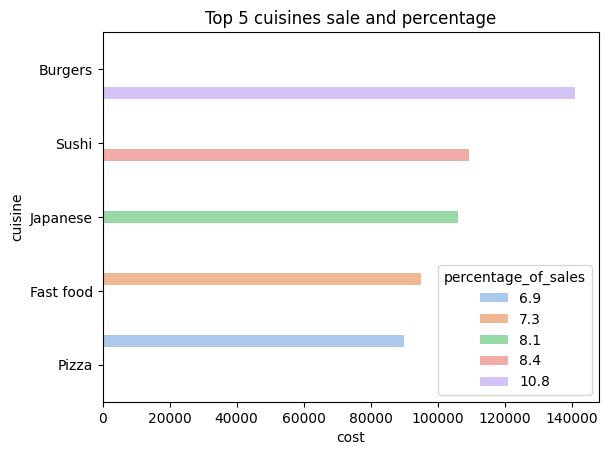

<Figure size 1800x1000 with 0 Axes>

In [171]:
# Cuisine distribution
sns.barplot(data=top_5_cuisines, x='cost', y='cuisine',palette='pastel',hue='percentage_of_sales',orient='h')
plt.title('Top 5 cuisines sale and percentage')
plt.figure(figsize=(18, 10))
plt.show()

Burgers account for a staggering ~11% of total delivery orders within 2 months. Asian food like Sushi and Japanese
account another 20% and fast food along with pizza stack up another 10% together. Only these 5 catgories covers almost
half of all deliveries !

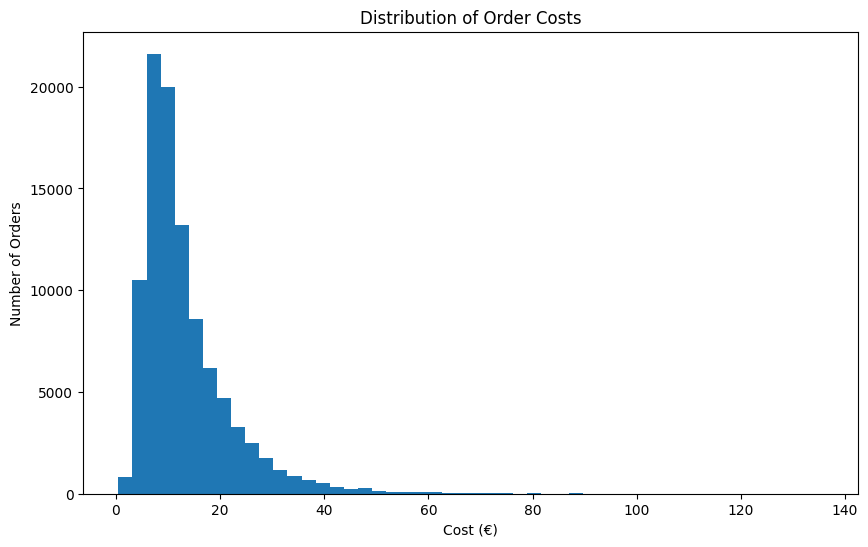

In [169]:
# Distribution of order costs
df['cost'].plot(kind='hist', bins=50, figsize=(10, 6))
plt.title('Distribution of Order Costs')
plt.xlabel('Cost (€)')
plt.ylabel('Number of Orders')
plt.show()


The distributiin for cost of orders is highly right skewed and will require high level of transformatioms
before being able to be used for forecasting. A cube root or square root transformation would give more 
statistically appropriate values.

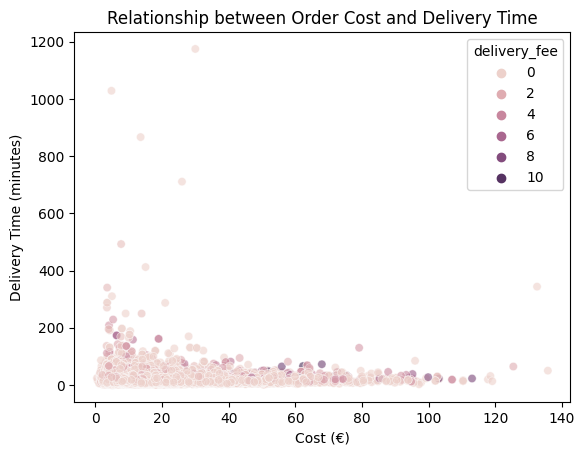

In [178]:
# Order vs Delivery cost
sns.scatterplot(data=df, x='cost', y='delivery_time', alpha=0.6,hue='delivery_fee')
plt.title('Relationship between Order Cost and Delivery Time')
plt.xlabel('Cost (€)')
plt.ylabel('Delivery Time (minutes)')
plt.show()

The scatter plot above highlights few concerning data points that has really high delivery time although in 
low order cost bracket and oncurring minimal delivery fee. These observations need more analysis to know whats
happening exactly here.